In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

import copy

In [2]:
matplotlib.rcParams.update({'font.size': 18})

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
%aimport activations
%aimport layers
%aimport autoencoder

# TEST

In [5]:
net = autoencoder.Autoencoder([
    layers.FCLayer((100, 50), activations.SigmoidActivationFunction(), use_bias=True),
    layers.FCLayer((50, 25), activations.ReluActivationFunction(), use_bias=True),
    layers.FCLayer((25, 25), activations.LinearActivationFunction()),
    layers.FCLayer((25, 50), activations.LeakyReluActivationFunction(), use_bias=False),
    layers.FCLayer((50, 100), activations.LinearActivationFunction()),
])

In [6]:
X = np.random.rand(100, 25)
p = np.random.rand(net.net.params_number)
eps = 1e-8

In [7]:
loss, loss_grad = net.compute_loss(X)

In [8]:
net1 = copy.deepcopy(net)
net1.net.set_weights(net.net.get_weights() + 1j*eps*p)
loss_test, loss_grad_test = net1.compute_loss(X)

###### Вычисление F($\theta$) и ее градиента

In [9]:
loss_grad.dot(p) - loss_test.imag / eps

-7.0388139761234925e-14

In [10]:
np.allclose(loss_grad.dot(p), loss_test.imag / eps)

True

###### Вычисление произведения гессиана F($\theta$) на вектор $p$

In [11]:
def cosine(x, y):
    return np.abs(x.dot(y) / np.sqrt(x.dot(x) * y.dot(y)))

In [12]:
Hp = net.compute_hessvec(p)
np.abs(Hp - loss_grad_test.imag / eps).max()

7.1853634153740131e-13

In [13]:
np.allclose(Hp, loss_grad_test.imag / eps)

True

In [14]:
cosine(Hp, loss_grad_test.imag / eps)

1.0000000000000002

###### Вычисление произведения гаусс-ньютоновской аппроксимации гессиана F($\theta$) на вектор $p$

In [15]:
Hpgn = net.compute_gaussnewtonvec(p)
cosine(Hp, Hpgn)

0.592473750605787

# MNIST

In [16]:
def show(img_flat, shape):
    plt.imshow(img_flat.reshape(shape), cmap='gray')
    plt.show()

In [17]:
def cmp_io(model, inp):
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 2, 1)
    plt.imshow(inp.reshape((28, 28)), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(model.net.compute_outputs(inp).reshape((28, 28)), cmap='gray')
    plt.axis('off')
    plt.show()

In [18]:
def plot_loss(hist_sgd, hist_rmsprop, hist_adam, arch_num):
    plt.figure(figsize=(15, 8))
    
    x = np.arange(len(hist_sgd['test_loss'])) + 1
    plt.plot(x, hist_sgd['test_loss'], label='SGD')
    plt.plot(x, hist_rmsprop['test_loss'], label='RMSprop')
    plt.plot(x, hist_adam['test_loss'], label='ADAM')
    
    plt.xticks(np.arange(1, len(hist_sgd['test_loss']), 2))
    plt.title('Architecture {}'.format(arch_num))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [19]:
mnist = fetch_mldata('MNIST original')

In [20]:
X = mnist.data.T / 255.
# X = normalize(mnist.data).T
y = mnist.target

In [21]:
train_indx, test_indx = train_test_split(np.arange(X.shape[1]), stratify=y)

In [22]:
X_train, X_test = X[:, train_indx], X[:, test_indx]
y_train, y_test = y[train_indx], y[test_indx]

In [23]:
EPOCH_NUM = 33

###### Архитектура 1

In [24]:
net1_sgd = autoencoder.Autoencoder([
    layers.FCLayer((X.shape[0], 2), activations.LinearActivationFunction(), use_bias=True),
    layers.FCLayer((2, X.shape[0]), activations.SigmoidActivationFunction()),
])
net1_rmsprop = copy.deepcopy(net1_sgd)
net1_adam = copy.deepcopy(net1_sgd)

In [25]:
%%time
hist1_sgd = net1_sgd.run_sgd(X_train, num_epoch=EPOCH_NUM, test_inputs=X_test)
hist1_rmsprop = net1_rmsprop.run_rmsprop(X_train, num_epoch=EPOCH_NUM, test_inputs=X_test)
hist1_adam = net1_adam.run_adam(X_train, num_epoch=EPOCH_NUM, test_inputs=X_test)

CPU times: user 5min 41s, sys: 2min 17s, total: 7min 59s
Wall time: 5min 15s


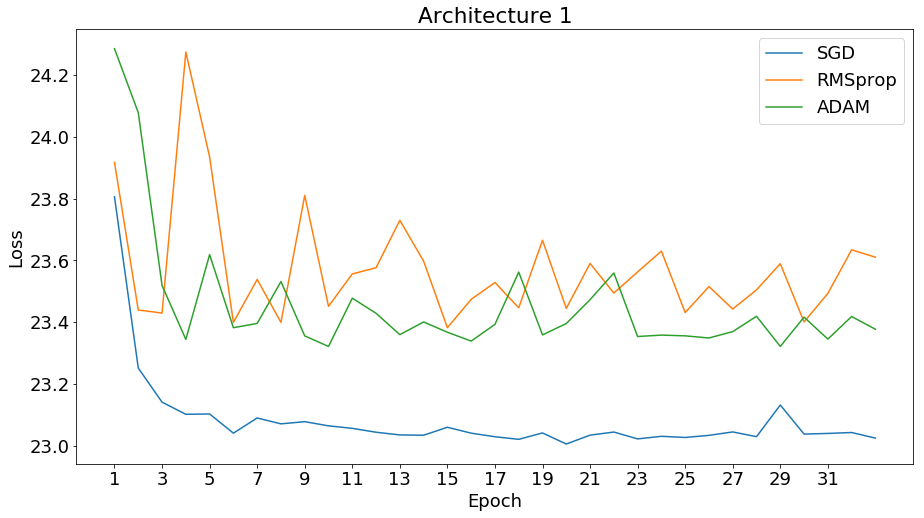

In [26]:
plot_loss(hist1_sgd, hist1_rmsprop, hist1_adam, 1)

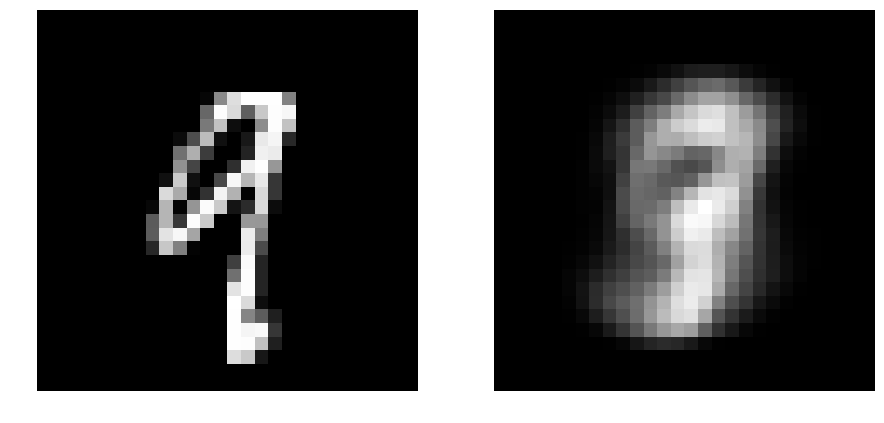

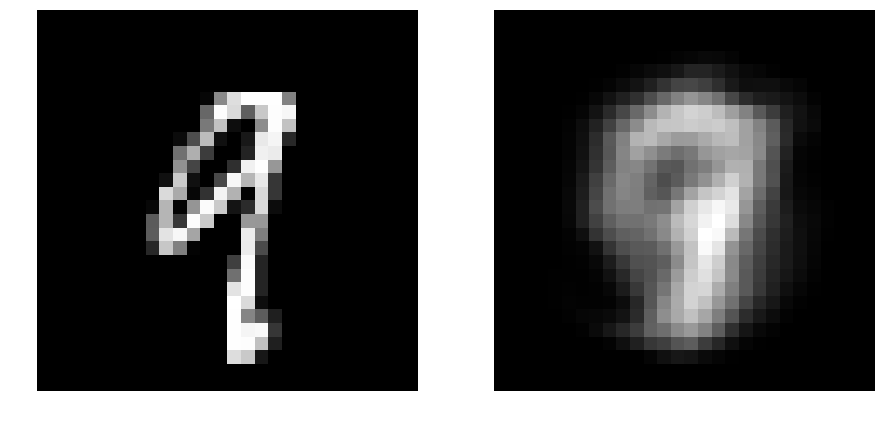

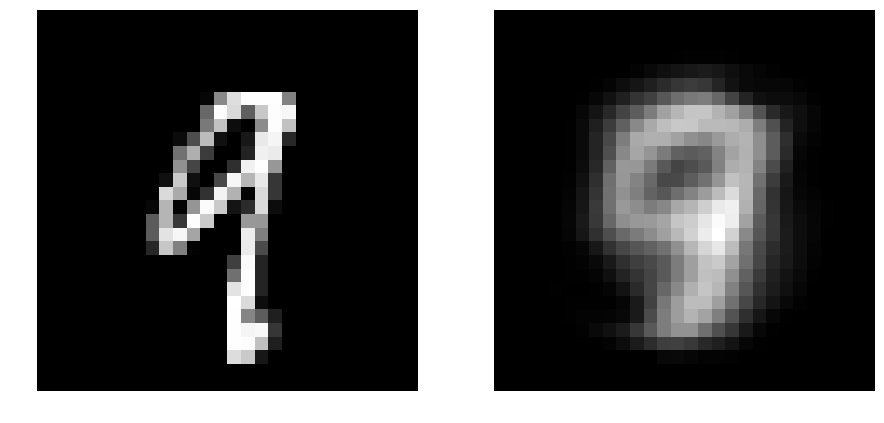

In [27]:
digit = X_test[:, np.where(y_test == 9)[0][0], np.newaxis]
cmp_io(net1_sgd, digit)
cmp_io(net1_rmsprop, digit)
cmp_io(net1_adam, digit)

###### Архитектура 2

In [28]:
net2_sgd = autoencoder.Autoencoder([
    layers.FCLayer((X.shape[0], 200), activations.LeakyReluActivationFunction(), use_bias=True),
    layers.FCLayer((200, 2), activations.LinearActivationFunction(), use_bias=True),
    layers.FCLayer((2, 200), activations.LeakyReluActivationFunction(), use_bias=True),
    layers.FCLayer((200, X.shape[0]), activations.SigmoidActivationFunction()),
])
net2_rmsprop = copy.deepcopy(net2_sgd)
net2_adam = copy.deepcopy(net2_sgd)

In [29]:
%%time
hist2_sgd = net2_sgd.run_sgd(X_train, num_epoch=EPOCH_NUM, test_inputs=X_test)
hist2_rmsprop = net2_rmsprop.run_rmsprop(X_train, num_epoch=EPOCH_NUM, test_inputs=X_test)
hist2_adam = net2_adam.run_adam(X_train, num_epoch=EPOCH_NUM, test_inputs=X_test)

CPU times: user 44min 6s, sys: 1h 22min 30s, total: 2h 6min 37s
Wall time: 17min 34s


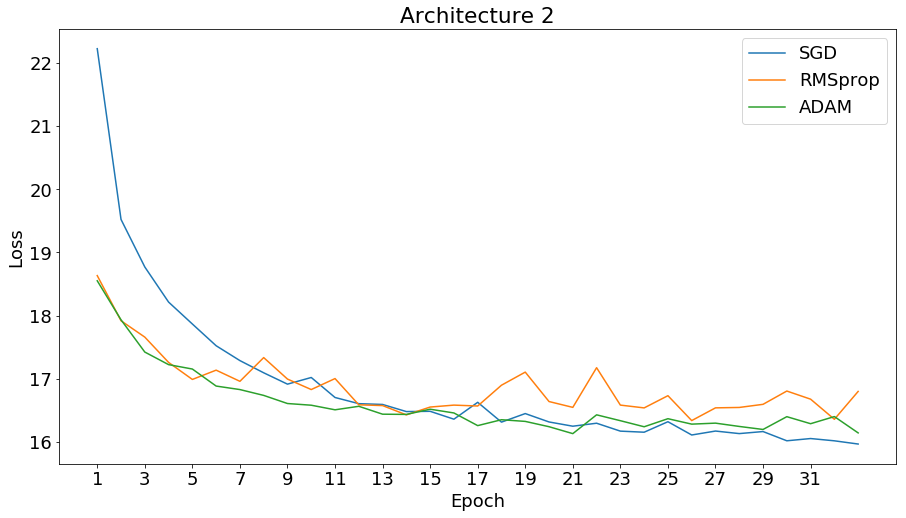

In [30]:
plot_loss(hist2_sgd, hist2_rmsprop, hist2_adam, 2)

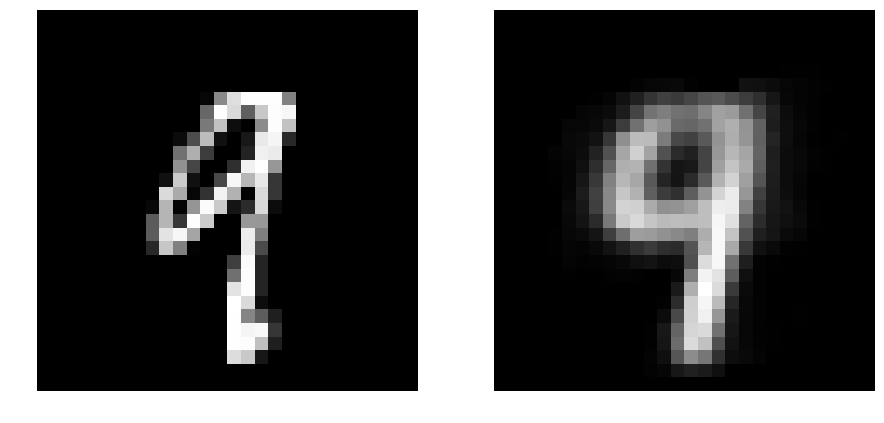

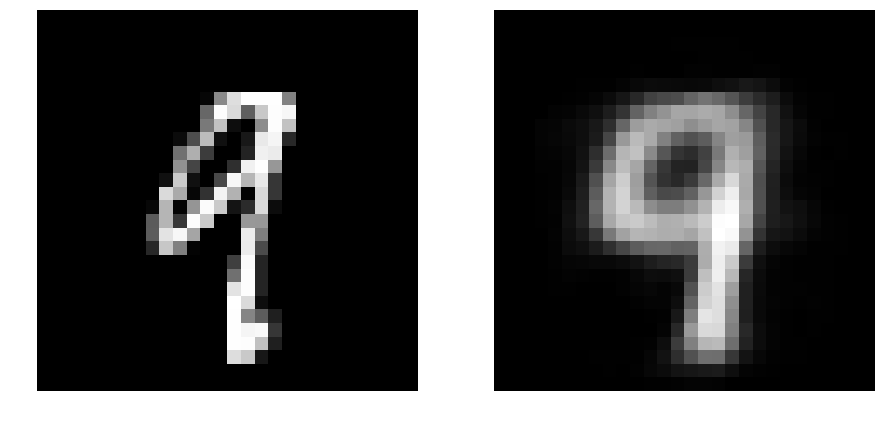

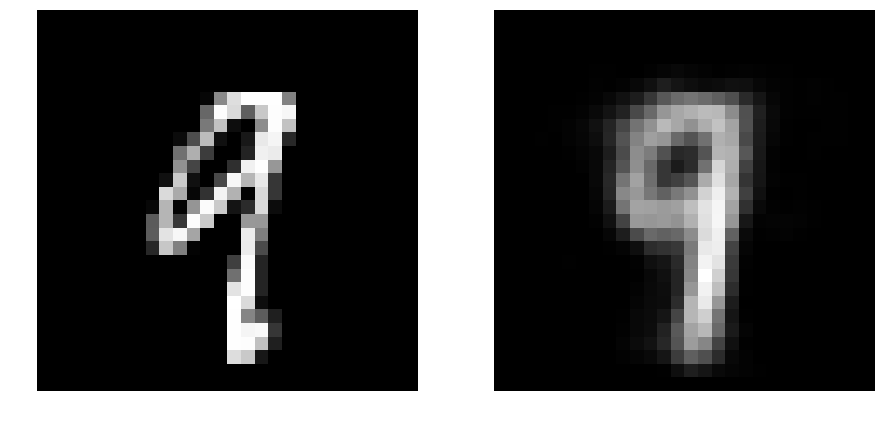

In [31]:
cmp_io(net2_sgd, digit)
cmp_io(net2_rmsprop, digit)
cmp_io(net2_adam, digit)

###### Архитектура 3

In [47]:
net3_sgd = autoencoder.Autoencoder([
    layers.FCLayer((X.shape[0], 400), activations.ReluActivationFunction(), use_bias=True),
    layers.FCLayer((400, 200), activations.LeakyReluActivationFunction(), use_bias=True),
    layers.FCLayer((200, 2), activations.LinearActivationFunction(), use_bias=True),
    layers.FCLayer((2, 200), activations.LeakyReluActivationFunction(), use_bias=True),
    layers.FCLayer((200, 400), activations.ReluActivationFunction(), use_bias=True),
    layers.FCLayer((400, X.shape[0]), activations.SigmoidActivationFunction()),
])
net3_rmsprop = copy.deepcopy(net3_sgd)
net3_adam = copy.deepcopy(net3_sgd)

In [48]:
%%time
hist3_sgd = net3_sgd.run_sgd(X_train, num_epoch=EPOCH_NUM, test_inputs=X_test)
hist3_rmsprop = net3_rmsprop.run_rmsprop(X_train, num_epoch=EPOCH_NUM, test_inputs=X_test)
hist3_adam = net3_adam.run_adam(X_train, num_epoch=EPOCH_NUM, test_inputs=X_test)

/home/ospanoff/Development/MMP_magistracy/DL/task1/code/activations.py:52: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


CPU times: user 1h 30min 32s, sys: 2h 39min 36s, total: 4h 10min 8s
Wall time: 34min 39s


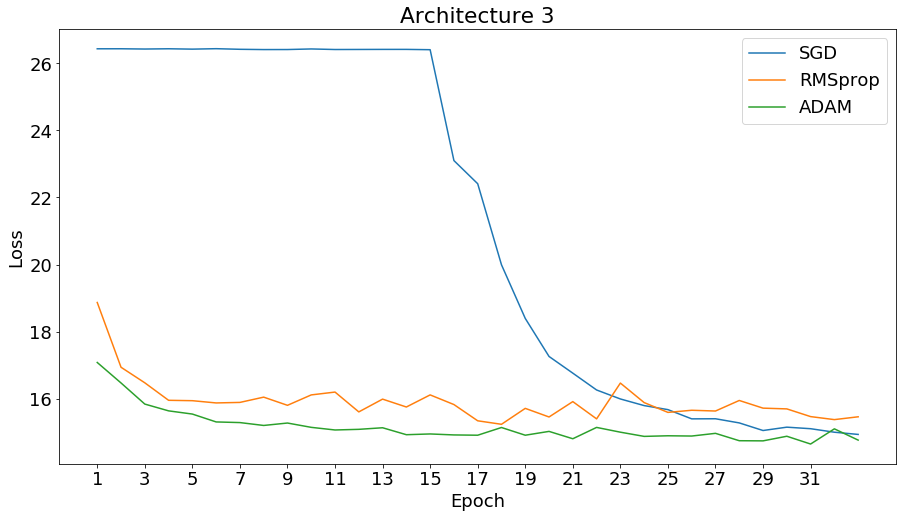

In [49]:
plot_loss(hist3_sgd, hist3_rmsprop, hist3_adam, 3)

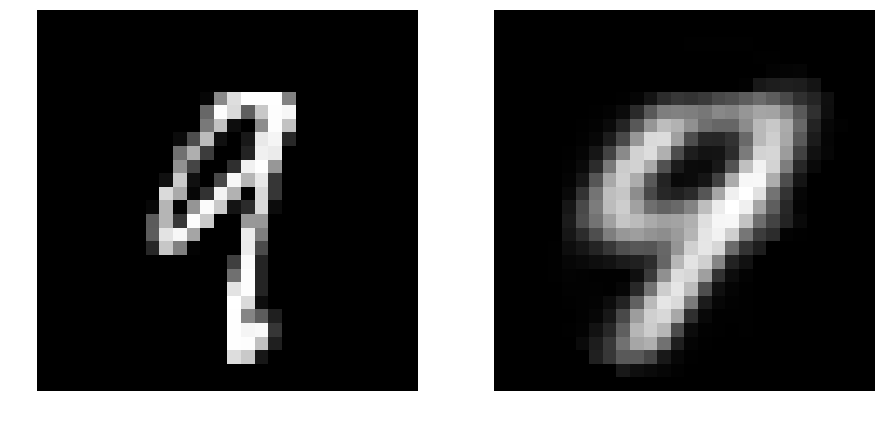

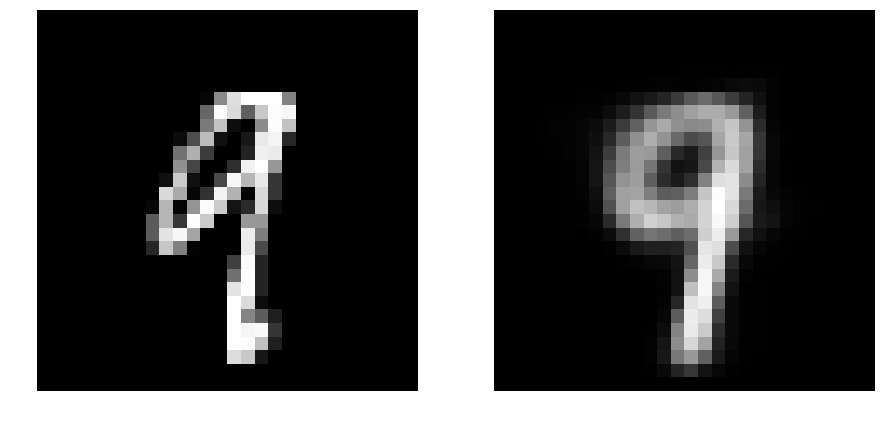

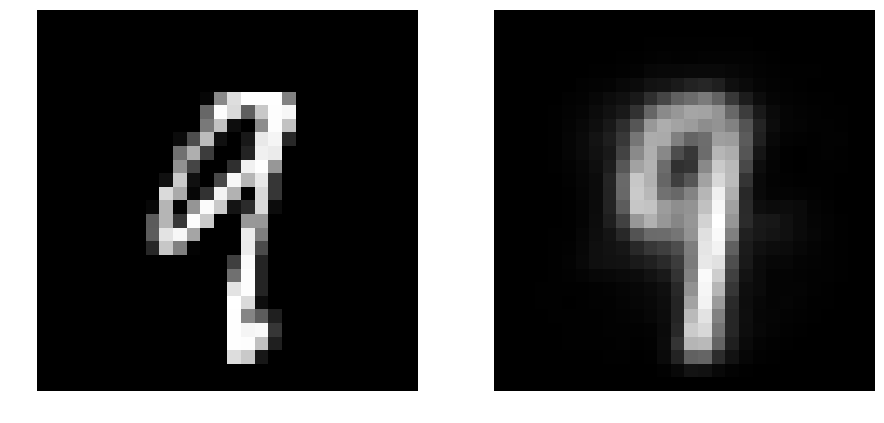

In [50]:
cmp_io(net3_sgd, digit)
cmp_io(net3_rmsprop, digit)
cmp_io(net3_adam, digit)

### Подбор параметров

In [72]:
net = autoencoder.Autoencoder([
    layers.FCLayer((X.shape[0], 200), activations.LeakyReluActivationFunction(), use_bias=True),
    layers.FCLayer((200, 2), activations.LinearActivationFunction(), use_bias=True),
    layers.FCLayer((2, 200), activations.LeakyReluActivationFunction(), use_bias=True),
    layers.FCLayer((200, X.shape[0]), activations.SigmoidActivationFunction()),
])
w_init = net.net.get_weights()
num_epochs = 15

In [73]:
ss = [1e-2, 1e-3, 1e-4, 1e-5]
mbs = [100, 500, 1000, 5000, 10000]

In [74]:
train_indx_1, test_indx_1 = train_test_split(np.arange(X_train.shape[1]), stratify=y_train)
X_train_1, X_test_1 = X_train[:, train_indx_1], X_train[:, test_indx_1]
y_train_1 = y_train[train_indx_1]

train_indx_2, test_indx_2 = train_test_split(np.arange(X_train_1.shape[1]), stratify=y_train_1)
X_train_2, X_test_2 = X_train_1[:, train_indx_2], X_train_1[:, test_indx_2]

In [75]:
hist_by_step = []
for step in ss:
    net.net.set_weights(w_init)
    hist_by_step += [net.run_adam(X_train_2, step_size=step, num_epoch=num_epochs, test_inputs=X_test_2, display=True)]

Epoch:	 Loss	 Norm of loss_grad	 Test loss	 Norm of test loss_grad
#1:	23.67284242454598	6.736445107199396	19.10906973130512	4.514098871926772
#2:	18.6443877536376	6.586074132984445	18.357748194333006	7.546778144109316
#3:	18.0434673037479	7.5595010831697165	17.903638871020373	6.750322346649153
#4:	17.73492067096099	8.388246007251047	17.77084499164883	6.8296716501325605
#5:	17.5029221253378	8.62600910523211	17.600429766047505	8.965716670501504
#6:	17.34091603807311	8.89070347792603	17.590757070292867	8.740725501171239
#7:	17.21142430858707	9.26760102127634	17.37383209915561	9.564235901546336
#8:	17.113830068326152	9.311557975704698	17.358272217258655	7.699257052395945
#9:	17.040440842405417	9.45696293579095	17.24543872538704	6.9541482544131314
#10:	16.940734956874998	9.14362523854661	17.249428418325714	10.691507866440537
#11:	16.83676791437091	9.222365251106924	17.12074489447347	7.108272550181016
#12:	16.792587440282652	9.461832591654817	17.122693875054477	7.391426013614089
#13:	16.778

In [76]:
hist_by_batch = []
for batch_size in mbs:
    net.net.set_weights(w_init)
    hist_by_batch += [net.run_adam(X_train_2, num_epoch=num_epochs, minibatch_size=batch_size, test_inputs=X_test_2, display=True)]

Epoch:	 Loss	 Norm of loss_grad	 Test loss	 Norm of test loss_grad
#1:	24.223748150504157	12.461804803300334	19.613582096381332	27.099706869903546
#2:	18.702342813051803	9.949213276316765	18.47551226637061	11.819246002429557
#3:	17.8771953228395	8.209144922160172	17.68553610744879	5.631895788705815
#4:	17.392570310372065	8.395575712633514	17.43972673826316	5.72665011878043
#5:	17.097372518222016	8.663264447938293	17.187414204133344	8.768743049517168
#6:	16.871987975258634	9.202133177457213	16.985370015583392	7.246585303127618
#7:	16.71826808618805	9.722775994084866	16.865904014397596	6.256591982561478
#8:	16.593719469000714	9.830329593711575	16.82998646191098	7.473161681600362
#9:	16.475388217679086	9.886356184357897	16.714183943965605	10.578405607070374
#10:	16.398725753543154	10.523854275606972	16.635600096512132	8.449432066374472
#11:	16.30918943131643	10.86485057338337	16.551698561866935	5.450425116122138
#12:	16.25212635351958	11.002003489142426	16.496578334023848	6.08010334443998

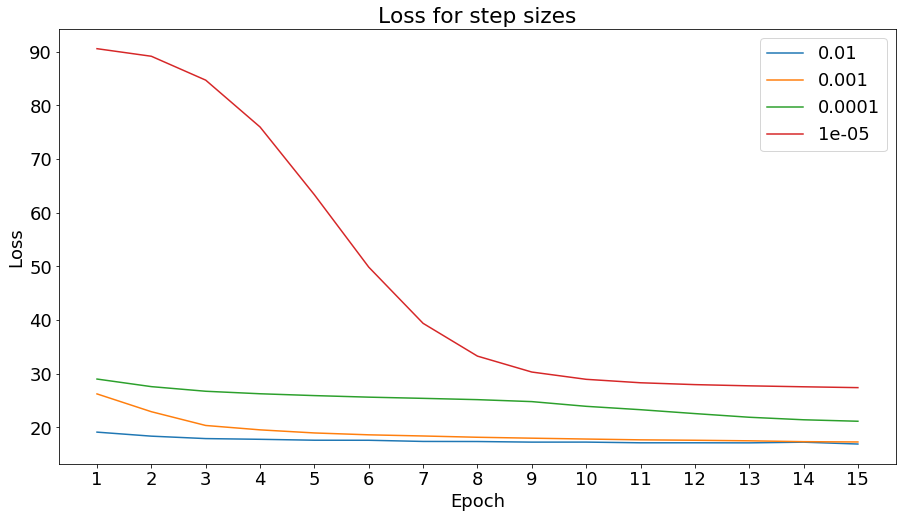

In [86]:
plt.figure(figsize=(15, 8))
plt.title('Loss for step sizes')
x = np.arange(len(hist_by_step[0]['test_loss'])) + 1
for i in range(len(ss)):
    plt.plot(x, hist_by_step[i]['test_loss'], label='{}'.format(ss[i]))
plt.legend()
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

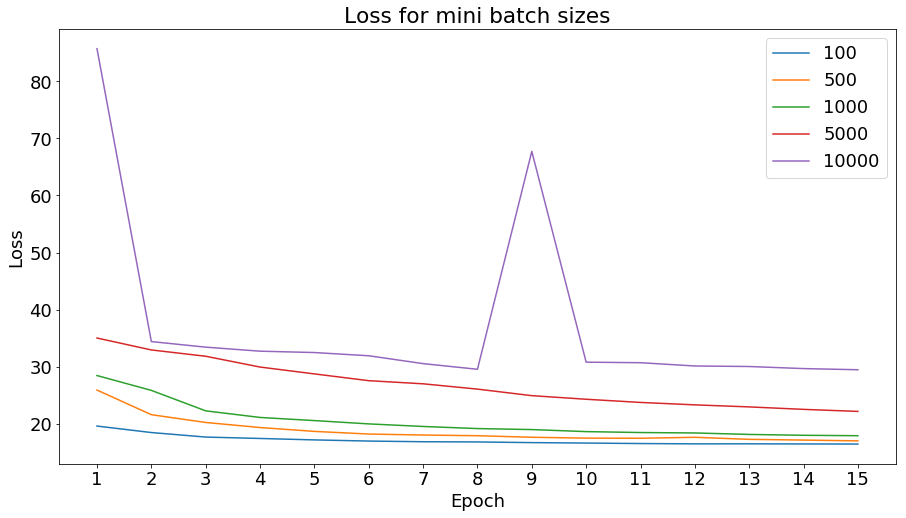

In [88]:
plt.figure(figsize=(15, 8))
plt.title('Loss for mini batch sizes')
x = np.arange(len(hist_by_batch[0]['test_loss'])) + 1
for i in range(len(mbs)):
    plt.plot(x, hist_by_batch[i]['test_loss'], label='{}'.format(mbs[i]))
plt.legend()
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Визуализация

In [89]:
net = autoencoder.Autoencoder([
    layers.FCLayer((X.shape[0], 200), activations.LeakyReluActivationFunction(), use_bias=True),
    layers.FCLayer((200, 2), activations.LinearActivationFunction(), use_bias=True),
    layers.FCLayer((2, 200), activations.LeakyReluActivationFunction(), use_bias=True),
    layers.FCLayer((200, X.shape[0]), activations.SigmoidActivationFunction()),
])
num_epochs = 50

In [91]:
hist = net.run_adam(X, num_epoch=num_epochs, display=True)

Epoch:	 Loss	 Norm of loss_grad
#1:	21.884807135599306	11.815864538979048
#2:	18.377081551274603	11.139714738865278
#3:	17.764537022379816	11.935272093991202
#4:	17.42405362900344	12.482963101252198
#5:	17.20383695451163	12.411095424018136
#6:	17.071536273395836	13.450026670535745
#7:	16.966330941284404	13.187206111652674
#8:	16.898842804257793	13.113129402077258
#9:	16.82274857361079	13.615416408314497
#10:	16.725102208478457	13.356582907283805
#11:	16.67685545026481	13.634077422203102
#12:	16.641117982633045	13.890654757795494
#13:	16.58705598827511	14.000730977496486
#14:	16.54513342619243	13.890113619622358
#15:	16.511976431048584	13.825908100423996
#16:	16.485741585020932	14.156893161739692
#17:	16.434883451293953	13.992868678933869
#18:	16.398532655079805	14.16921664496391
#19:	16.370155609770475	14.011266240788403
#20:	16.370942972903393	14.639781755066439
#21:	16.328887931723443	14.478295779411955
#22:	16.297755211398048	14.471941912971246
#23:	16.263950749816022	14.52063563889

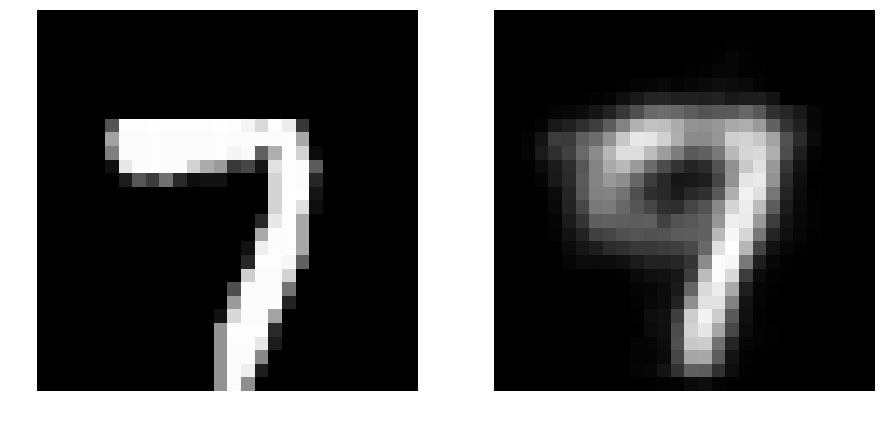

In [101]:
cmp_io(net, X[:, [44884]])

In [103]:
X_pred = net.net.compute_outputs(X)
X_2dim = net.net.get_activations(1)

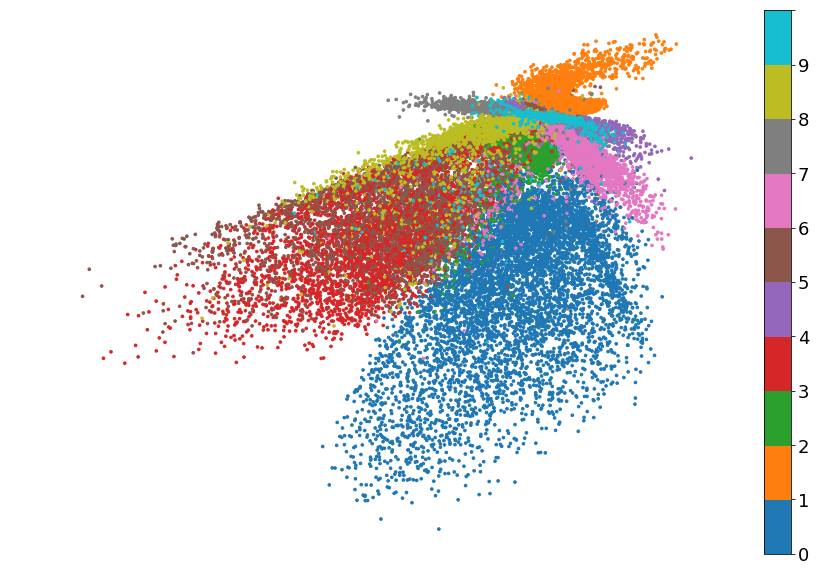

In [148]:
plt.figure(figsize=(15, 10))
plt.scatter(X_2dim[0], X_2dim[1], c=y, s=7, cmap='tab10')
plt.axis('off')

cb = plt.colorbar()
loc = np.arange(0, 10, 9/10)
cb.set_ticks(loc[:-1])
cb.set_ticklabels(np.arange(10))

plt.show()